In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import timm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
class CatDogClassifier(nn.Module):
    def __init__(self, num_labels=2, backbone_name='convnextv2_base.fcmae_ft_in22k_in1k', pretrained_backbone=True):
        super().__init__()
        
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained_backbone,
            num_classes=0,  # No classification head
        )
        feat_dim = self.backbone.num_features
        self.proj = nn.Linear(feat_dim, 512)

        self.classifier = nn.Linear(512, 1)  # 1 output cho binary classification

    def forward(self, images):
        b, c, h, w = images.shape
        feats = self.backbone(images).view(b, -1)
        feats = self.proj(feats)
        logits = self.classifier(feats)
        return logits

# Load lại model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CatDogClassifier(backbone_name='convnextv2_base.fcmae_ft_in22k_in1k', pretrained_backbone=False)
model.load_state_dict(torch.load('/kaggle/input/dogcat/pytorch/default/1/catdog_final.pth', map_location=device))
model = model.to(device)
model.eval()

# Chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dữ liệu test
test_dataset = datasets.ImageFolder(root='/kaggle/input/cat-and-dog/test_set/test_set', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Đánh giá Accuracy
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        predicted = (preds > 0.5).int().squeeze()

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"\n✅ Test Accuracy: {accuracy:.2f}%")

/tmp/ipykernel_31/103507956.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/dogcat/pytorch/default/1/catdog_final.pth', 


✅ Test Accuracy: 99.80%


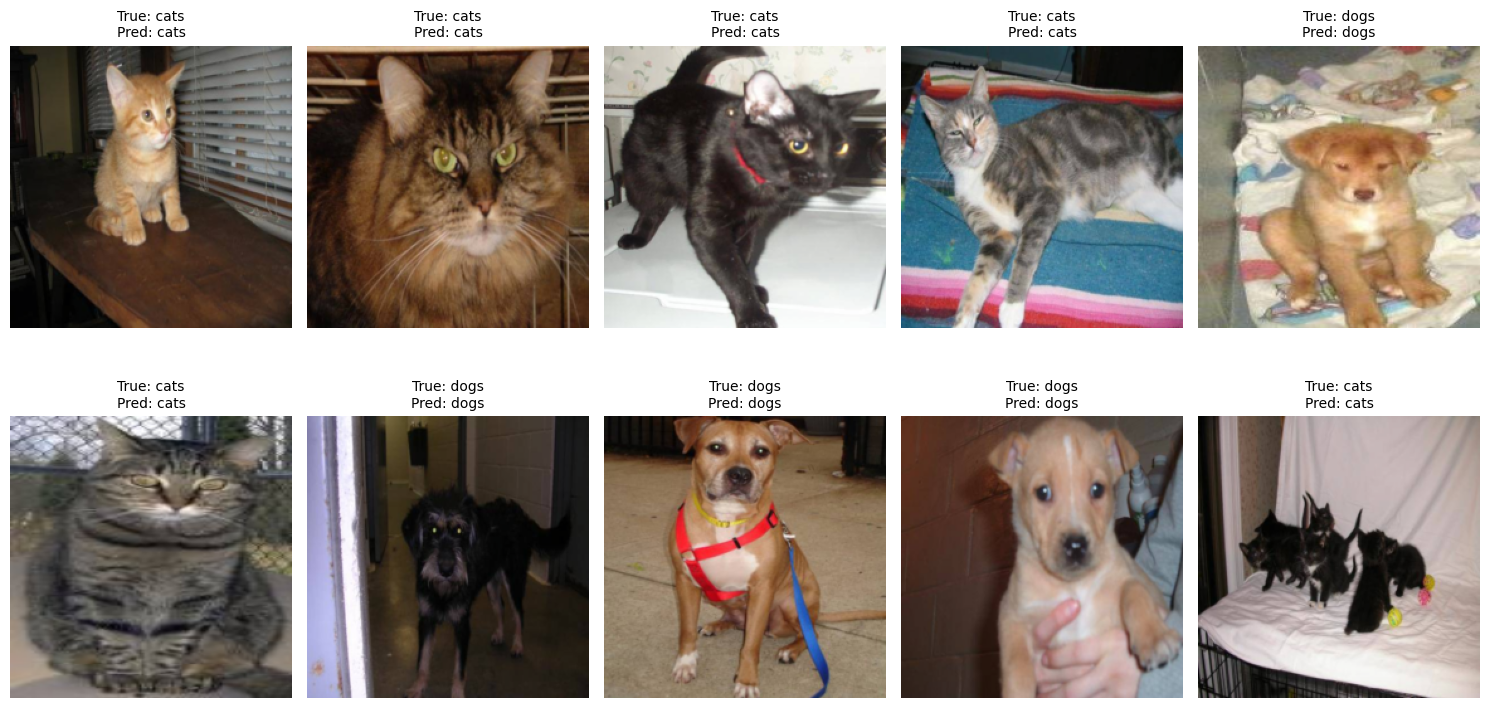

In [6]:
# Load toàn bộ test dataset vào RAM
all_images = []
all_labels = []

for images, labels in test_loader:
    all_images.append(images)
    all_labels.append(labels)

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Random chọn 10 index bất kỳ
indices = random.sample(range(len(all_images)), 10)
sample_images = all_images[indices]
sample_labels = all_labels[indices]

sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

# Predict
with torch.no_grad():
    outputs = model(sample_images)
    preds = torch.sigmoid(outputs)
    predicted = (preds > 0.5).int().squeeze()

# Mapping index -> class name
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}  # ví dụ {0: 'cats', 1: 'dogs'}

# Vẽ 10 hình ngẫu nhiên 
plt.figure(figsize=(15, 8))
for i in range(10):
    img = sample_images[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize ảnh
    img = np.clip(img, 0, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

    pred_label = idx_to_class[int(predicted[i])]
    true_label = idx_to_class[int(sample_labels[i])]
    plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)

plt.tight_layout()
plt.show()